#Apprentissage profond pour la détection de objets dans des images acoustiques

# Librairies

Obtention des modules en clonant le repo sur GitHub

In [1]:
!git clone -q https://github.com/mateobentura/acoustic-deep-incremental-learning.git
!mv acoustic-deep-incremental-learning/* .; rm -rf acoustic-deep-incremental-learning

Téléchargement des poids des réseaux de neurones

In [ ]:
!gdown -q --id 1KDXaTwx5emgJOYhTN3o8HNYpwL5a9ib3
!unzip -qo weights.zip
!rm weights.zip

In [2]:
!pip -qq install segmentation_models
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import ImageSynthetique as imsy
from ImageSynthetique import timing
from tensorflow import keras
import Dataset as ds
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

     |████████████████████████████████| 50 kB 4.0 MB/s 
Segmentation Models: using `tf.keras` framework.


# Images synthétiques



## Création d'une image

Un outil pour la génération d'images synthétiques a été créé, qui permet notamment d'ajouter les objets concenrés, en précisant leurs caractéristiques. Tout d'abord, on initialise un objet de la classe `ImageSynthétique` :

In [4]:
image_synth = imsy.ImageSynthetique(height=300, width=640, noise_lvl=0.08, seed=30)

Ensuite, on défine les paramètres de l'objet que l'on veut créer. Par exemple, dans le code ci-dessous, on crée un object de type 'échelle'. Ceci consiste d'un groupe de lignes, à partir d'un point donné, avec un espacement constante et une longueur donnée, plus une variation aléatoire. Le paramètre `seed` permet d'avoir une image pseudo-aléatoire qui peut être recréée avec le même seed.

In [5]:
image_synth.add_ladder(starting_pt=[100, 25],
                spacing=5, length=12,
                l_var=2, lines=10, seed=30)

Une fois que les ajouts sont terminés, l'algorithme additionne le bruit et limite les pixels à l'intervalle `[0, 255]`.



In [6]:
image_synth.finish()

## Visualisation

La classe s'occupe aussi de la labelisation et segmentation de l'image. Pour afficher l'image resultant, on utilise la méthode `show`.



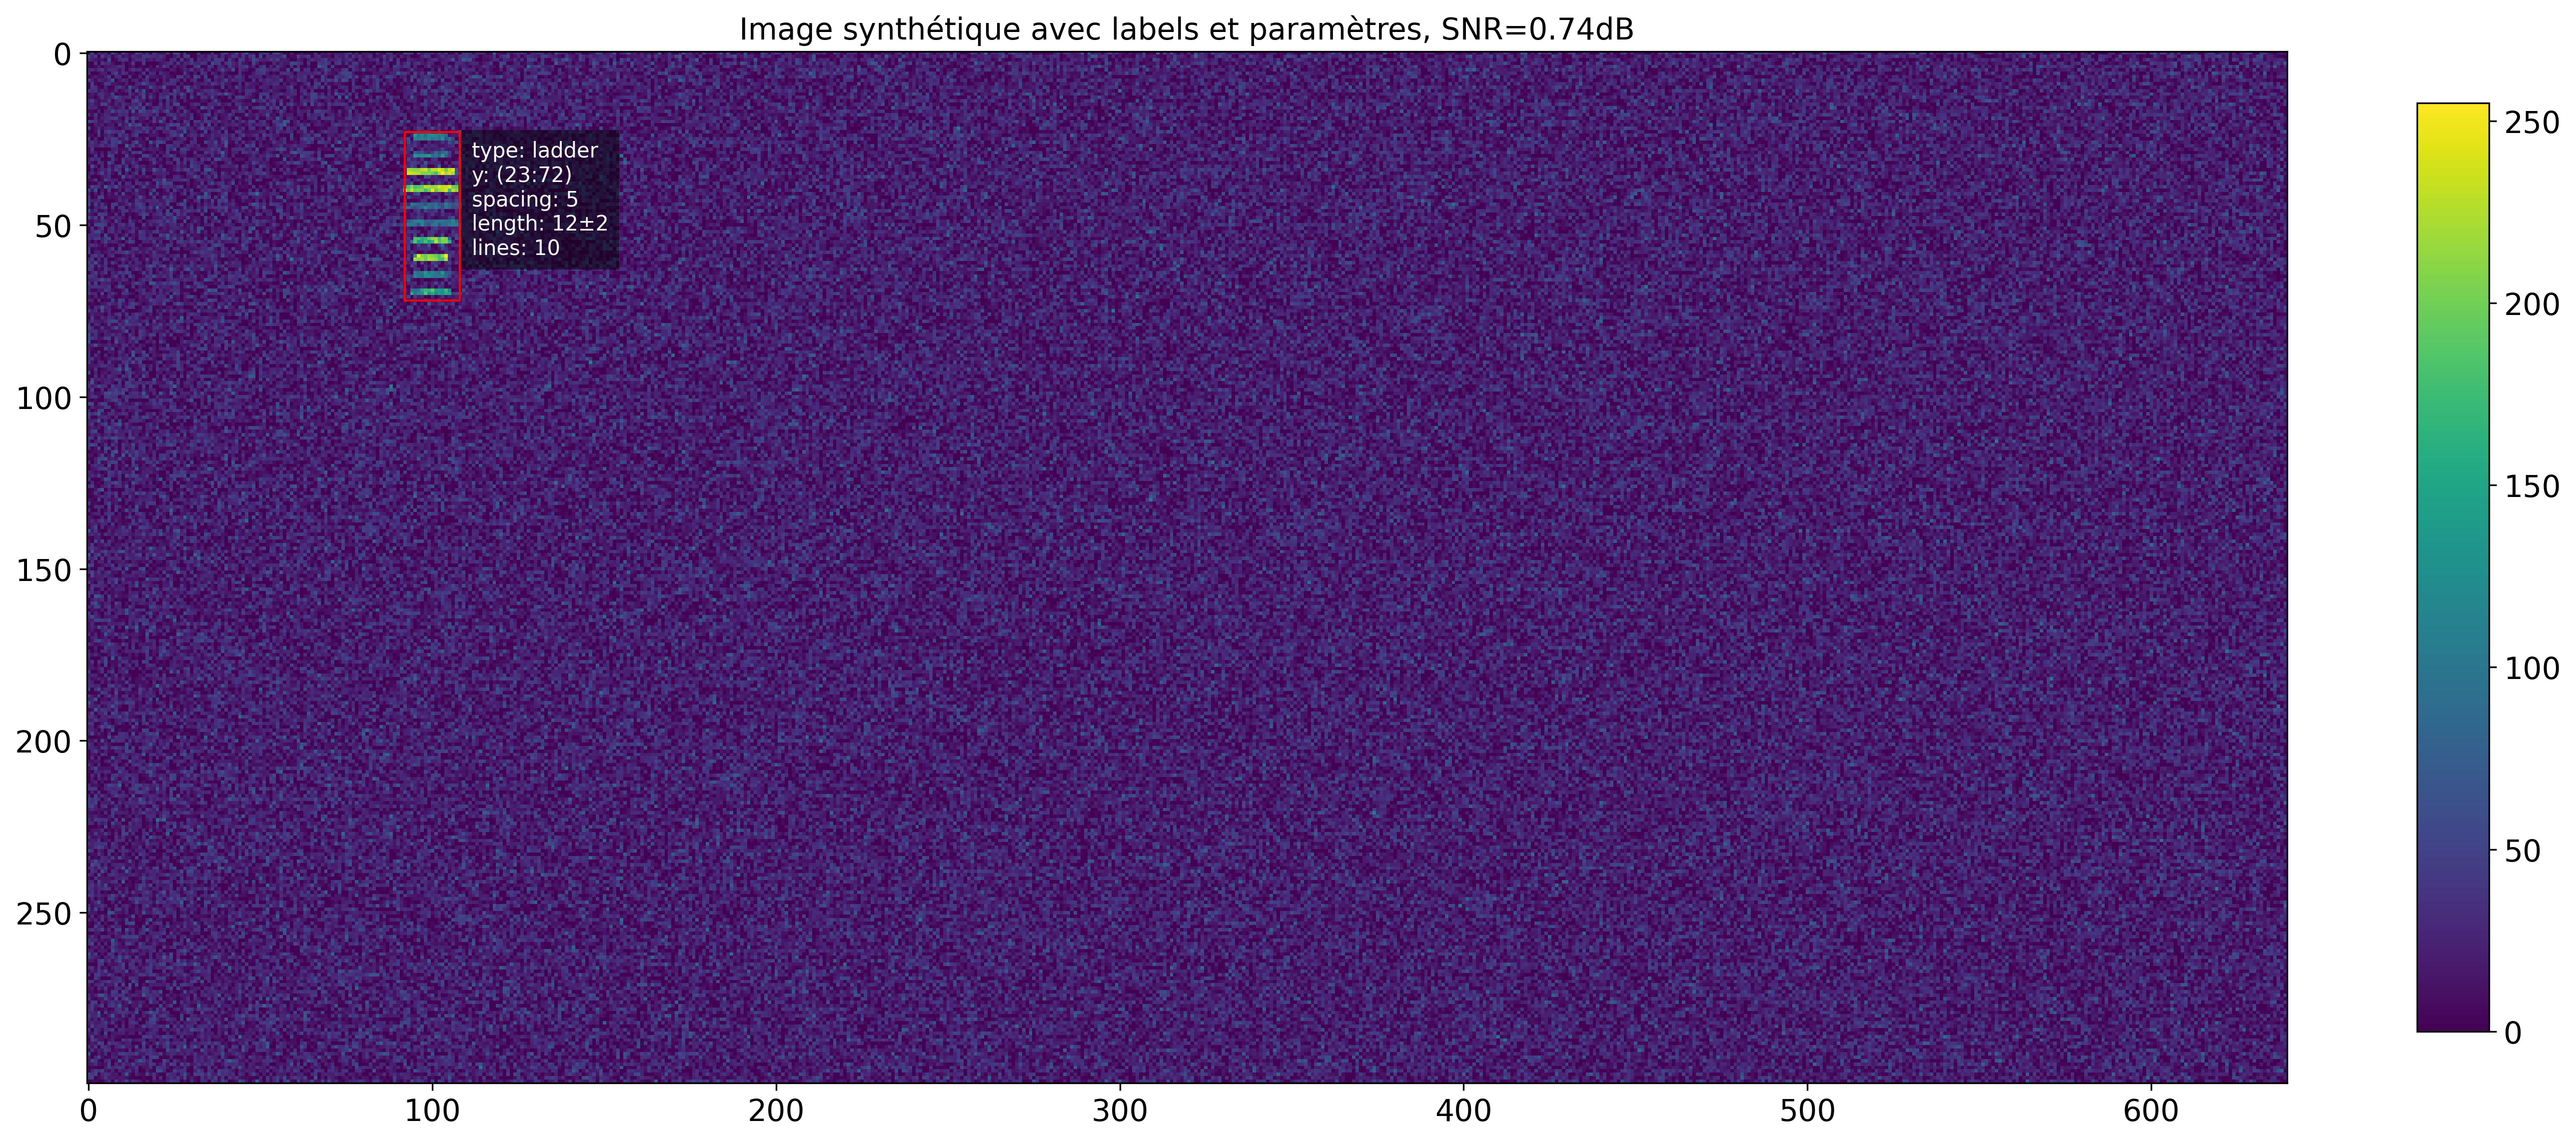

In [ ]:
image_synth.show()

### Génération des exemples pour le réseau

Pour générer les exemples que l'on utilisera pour entraîner ou tester le réseaux, il faut faire un découpage à travers un fenêtre glissante. La suivante méthode implémente cela.

In [8]:
image_synth.sliding_window(window_size=32, step_h=1, step_v=1);

On peut accéder aux examples dans l'attribute `labels`. Il s'agit d'une dictionnaire qui contient les clés 'classif' et 'segm', contenant les labels pour le réseaux de classification et segmentation, respectivement. Voici l'exemple pour le réseau de classification, qui exige, pour chaque fenêtre, un entier indicant l'appartenance ou non à la classe:

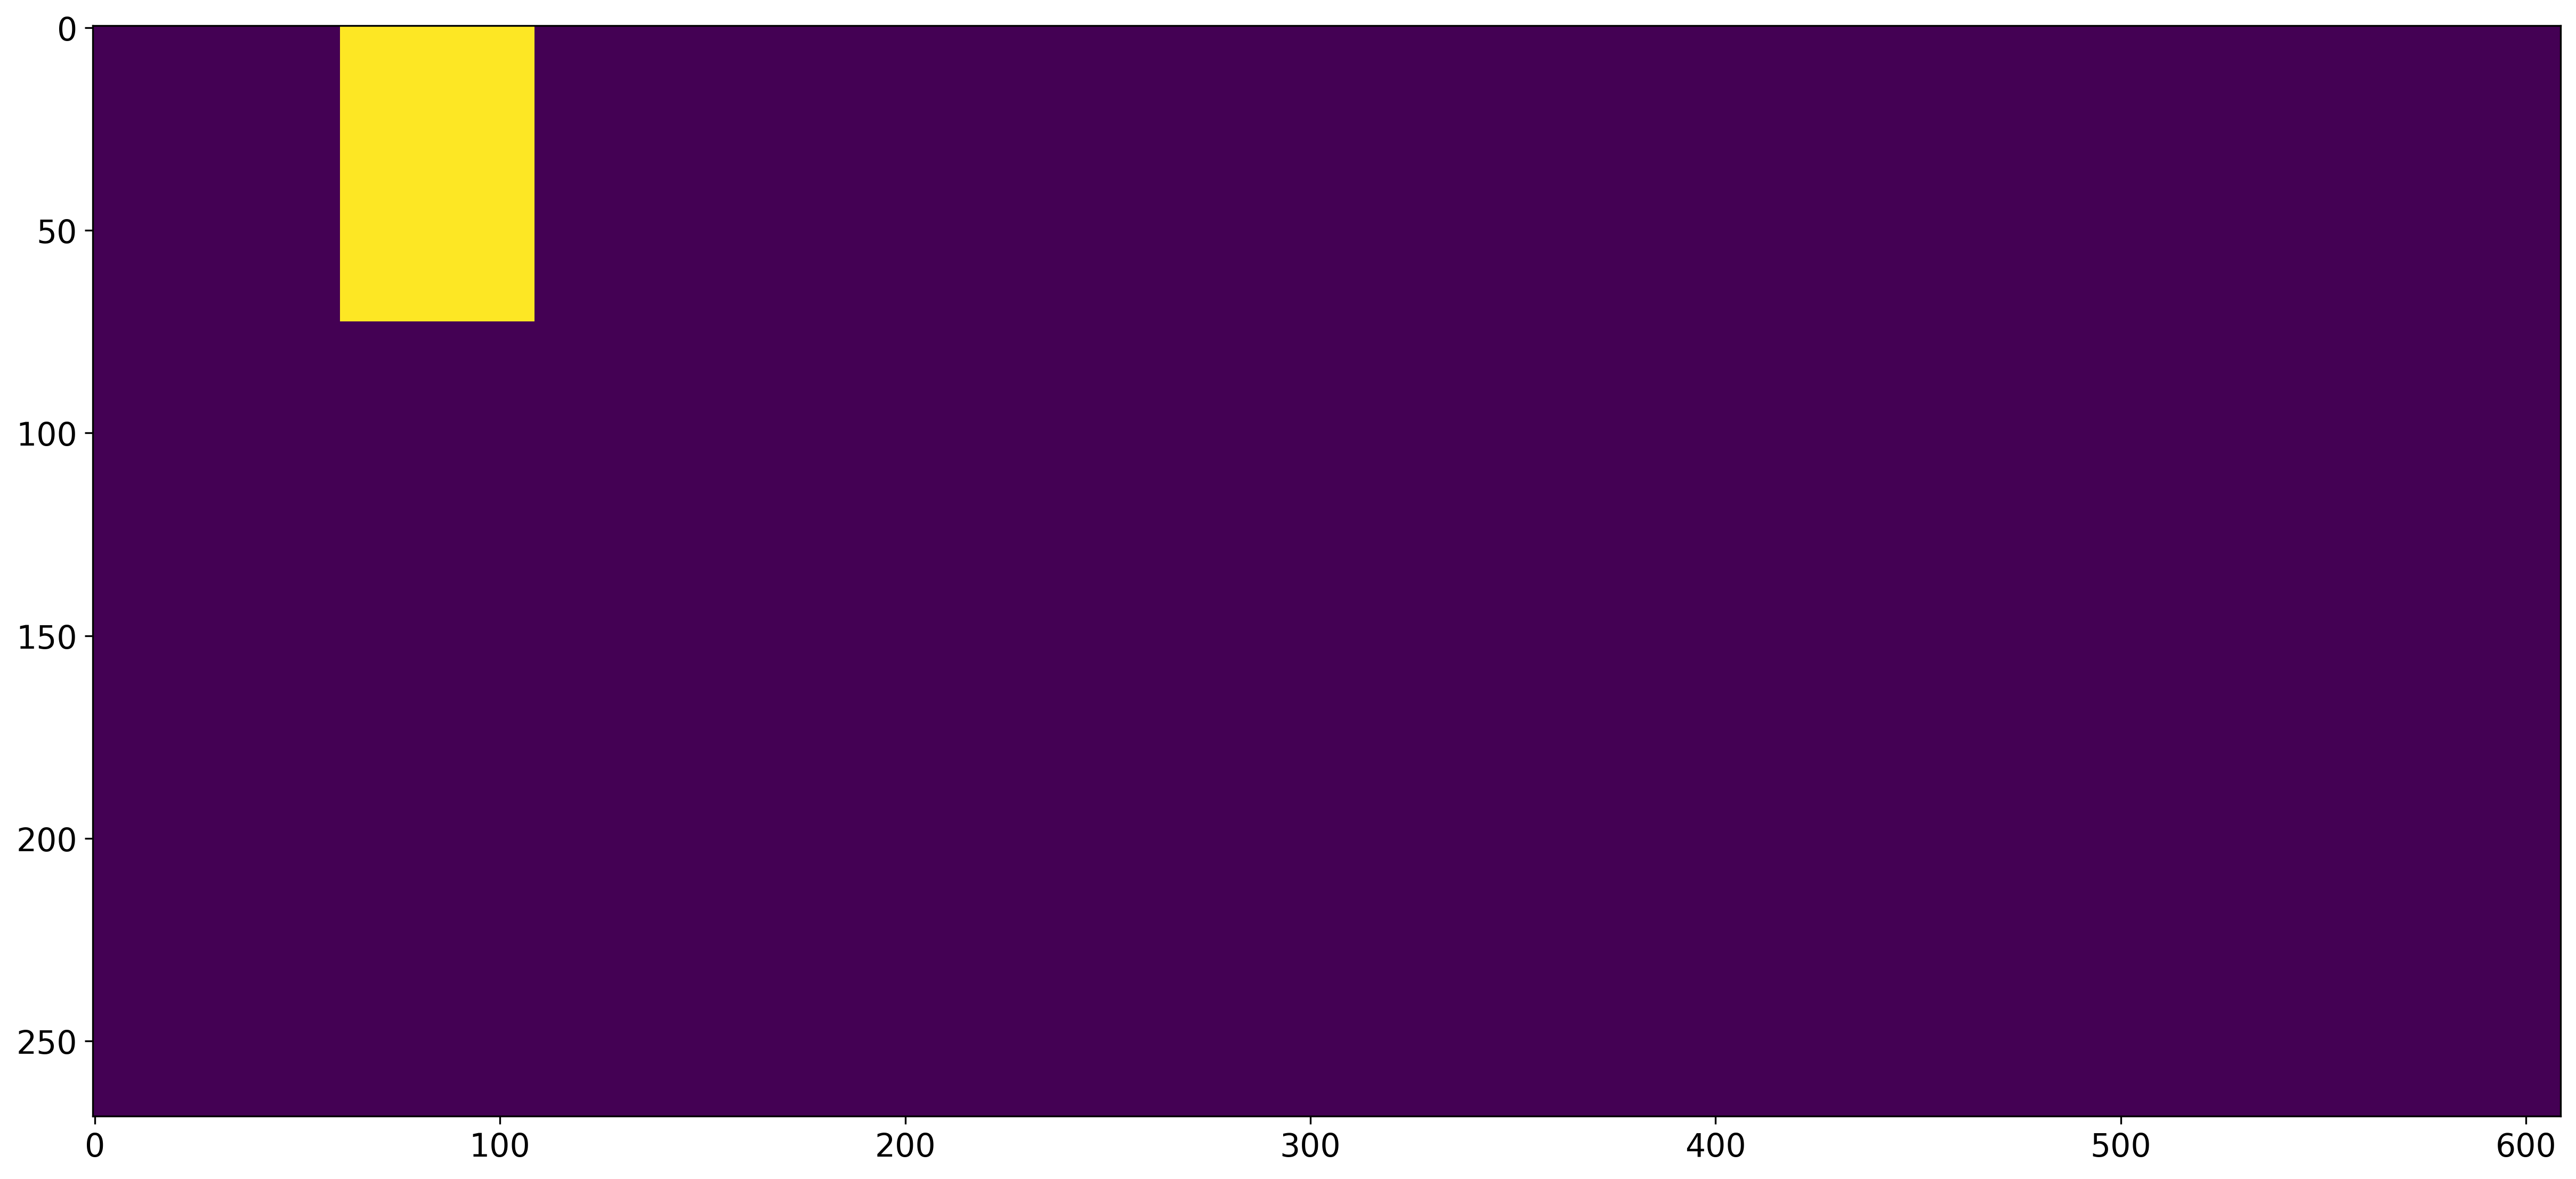

In [11]:
plt.imshow(image_synth.labels['classif'])

Pour le cas de la segmentation, il est plus difficile de visualiser la totalité des exemples. On prendra donc une fenêtre qui contient effectivement des barreaux et on affichera la sous-image (accessible dans l'attribute `crops`) et sa segmentation.

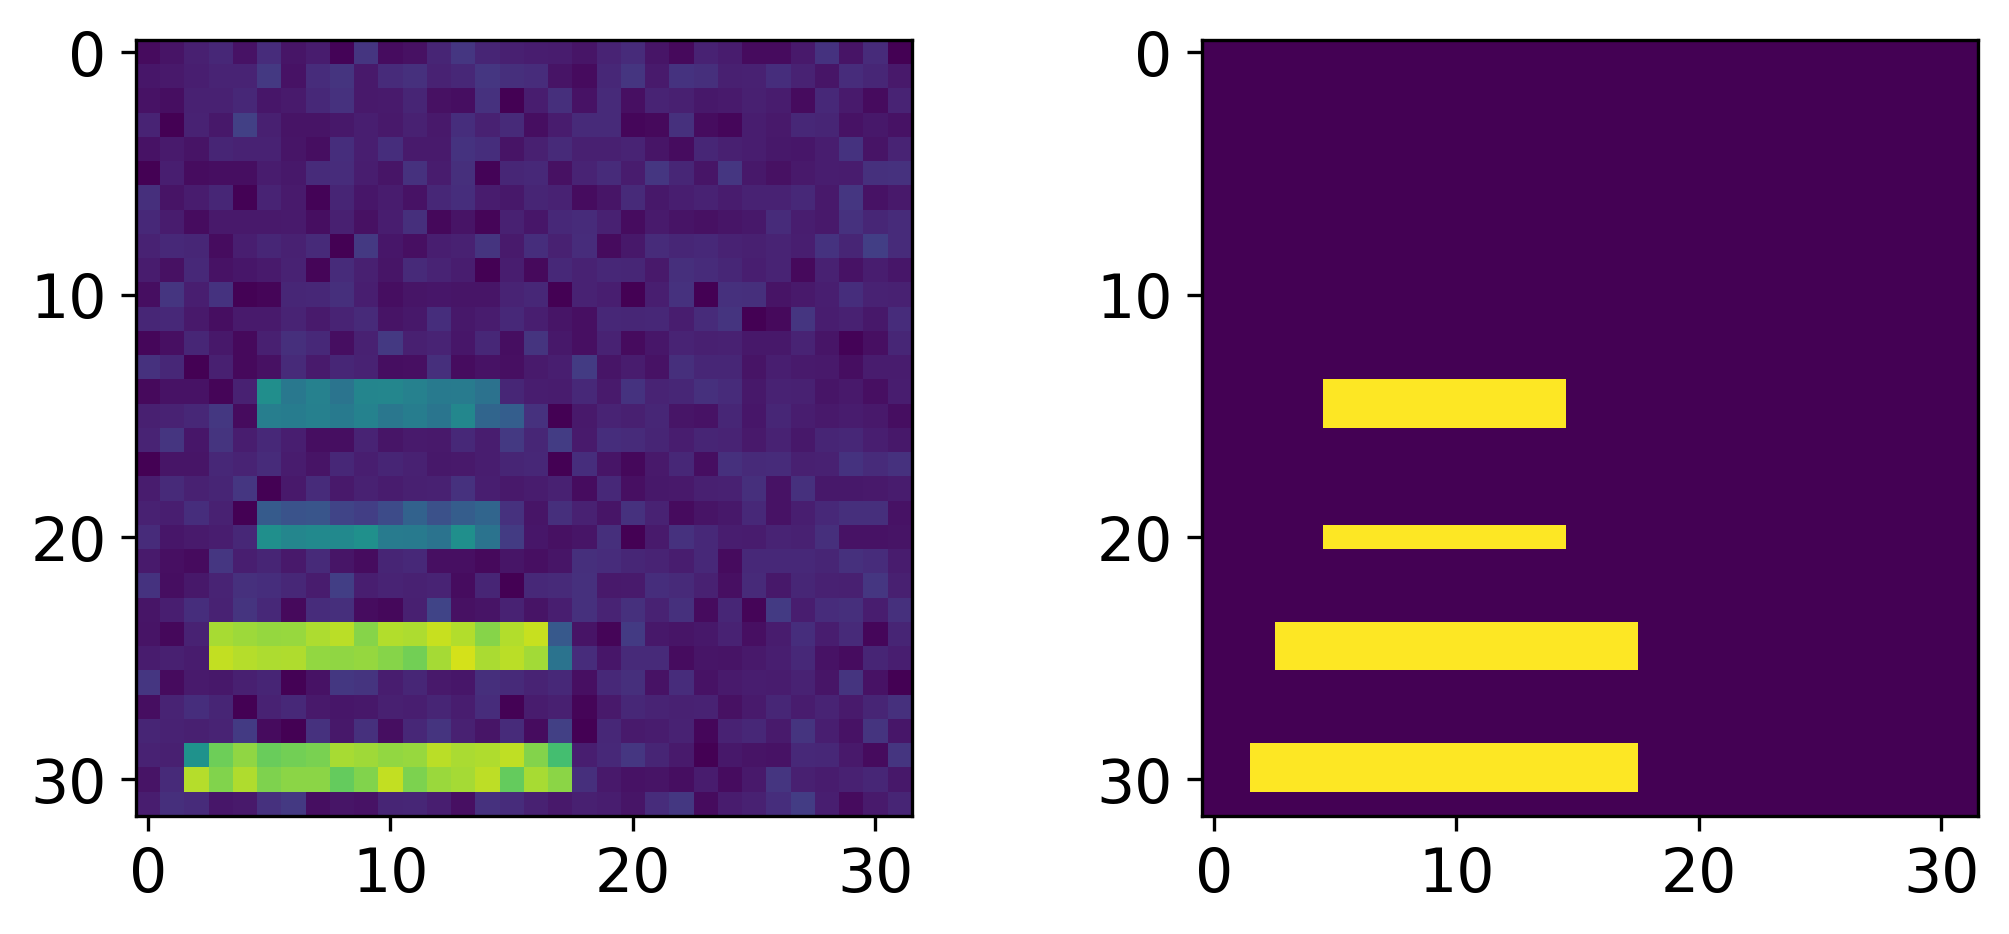

In [30]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(image_synth.crops[10,90], vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(image_synth.labels['segm'][10,90].reshape(32,32))
plt.show()

# Aprentissage profond

## Initialisation des modèles

### Modèle de classification

Un deuxième module personnalisé (`Dataset`, importé comme `ds`) est utilisé pour créer les differents modèles qui seront utilisés lors de l'apprentissage avec les données. Il se sert notamment de la librairie Keras pour construire les modèles et couches.

Le but de ce projet a été d'analyser les possibilités qui offre l'apprentissage par transfert, c'est-à-dire, de réutiliser des réseaux de neurones pré-entraînés de base et adapter la sortie aux problème particulier.

On définit dans un premier temps le modèle de classification. Ceci fera une classification d'un ensemble de sous-images générées à partir de l'image d'entrée. Les sous-images d'entrée seront d'une taille de 32×32.

In [ ]:
classification_model = ds.classification_model(img_shape=(32,32))

94773248/94765736 [==============================] - 1s 0us/step


En utilisant la fonction `plot_model` de **Keras**, on peut voir l'architecture du réseau. L'entrée en niveaux de gris passe par une couche de convolution qui permet d'adapter au réseau pre-entraîné.

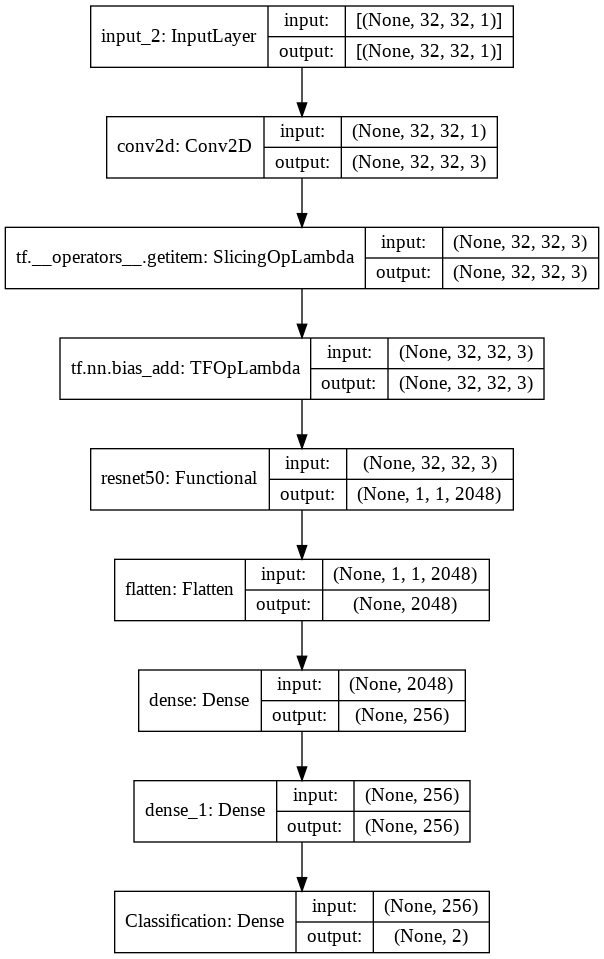

In [ ]:
keras.utils.plot_model(classification_model, to_file='classification_model.png', show_shapes=True)

Nous allons maintenant charger les poids appris pour le réseau de classification : 

In [ ]:
classification_model.load_weights('classif/classif')

### Modèle de segmentation

On initialise le modèle de segmentation de façon similaire. Le submodule 'Unet' contient d'ailleurs l'implementation du modèle [Unet](https://arxiv.org/abs/1505.04597) issue de [segmentation_models](https://github.com/qubvel/segmentation_models).

85524480/85521592 [==============================] - 1s 0us/step


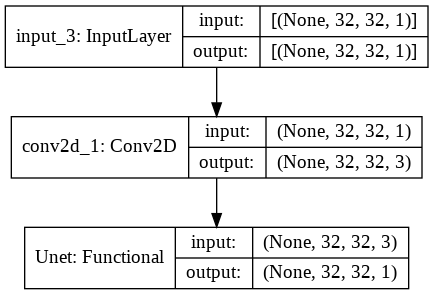

In [ ]:
segmentation_model = ds.segmentation_model(img_shape=(32,32))
keras.utils.plot_model(segmentation_model, to_file='segmentation_model.png', show_shapes=True)

In [ ]:
segmentation_model.load_weights('segm/segm')

## Testing

### Image de test

Il faut créer une nouvelle image de test. Pour cette image, on crée une liste de espacements et on ajoute ensuite une échelle avec chaque espacement:

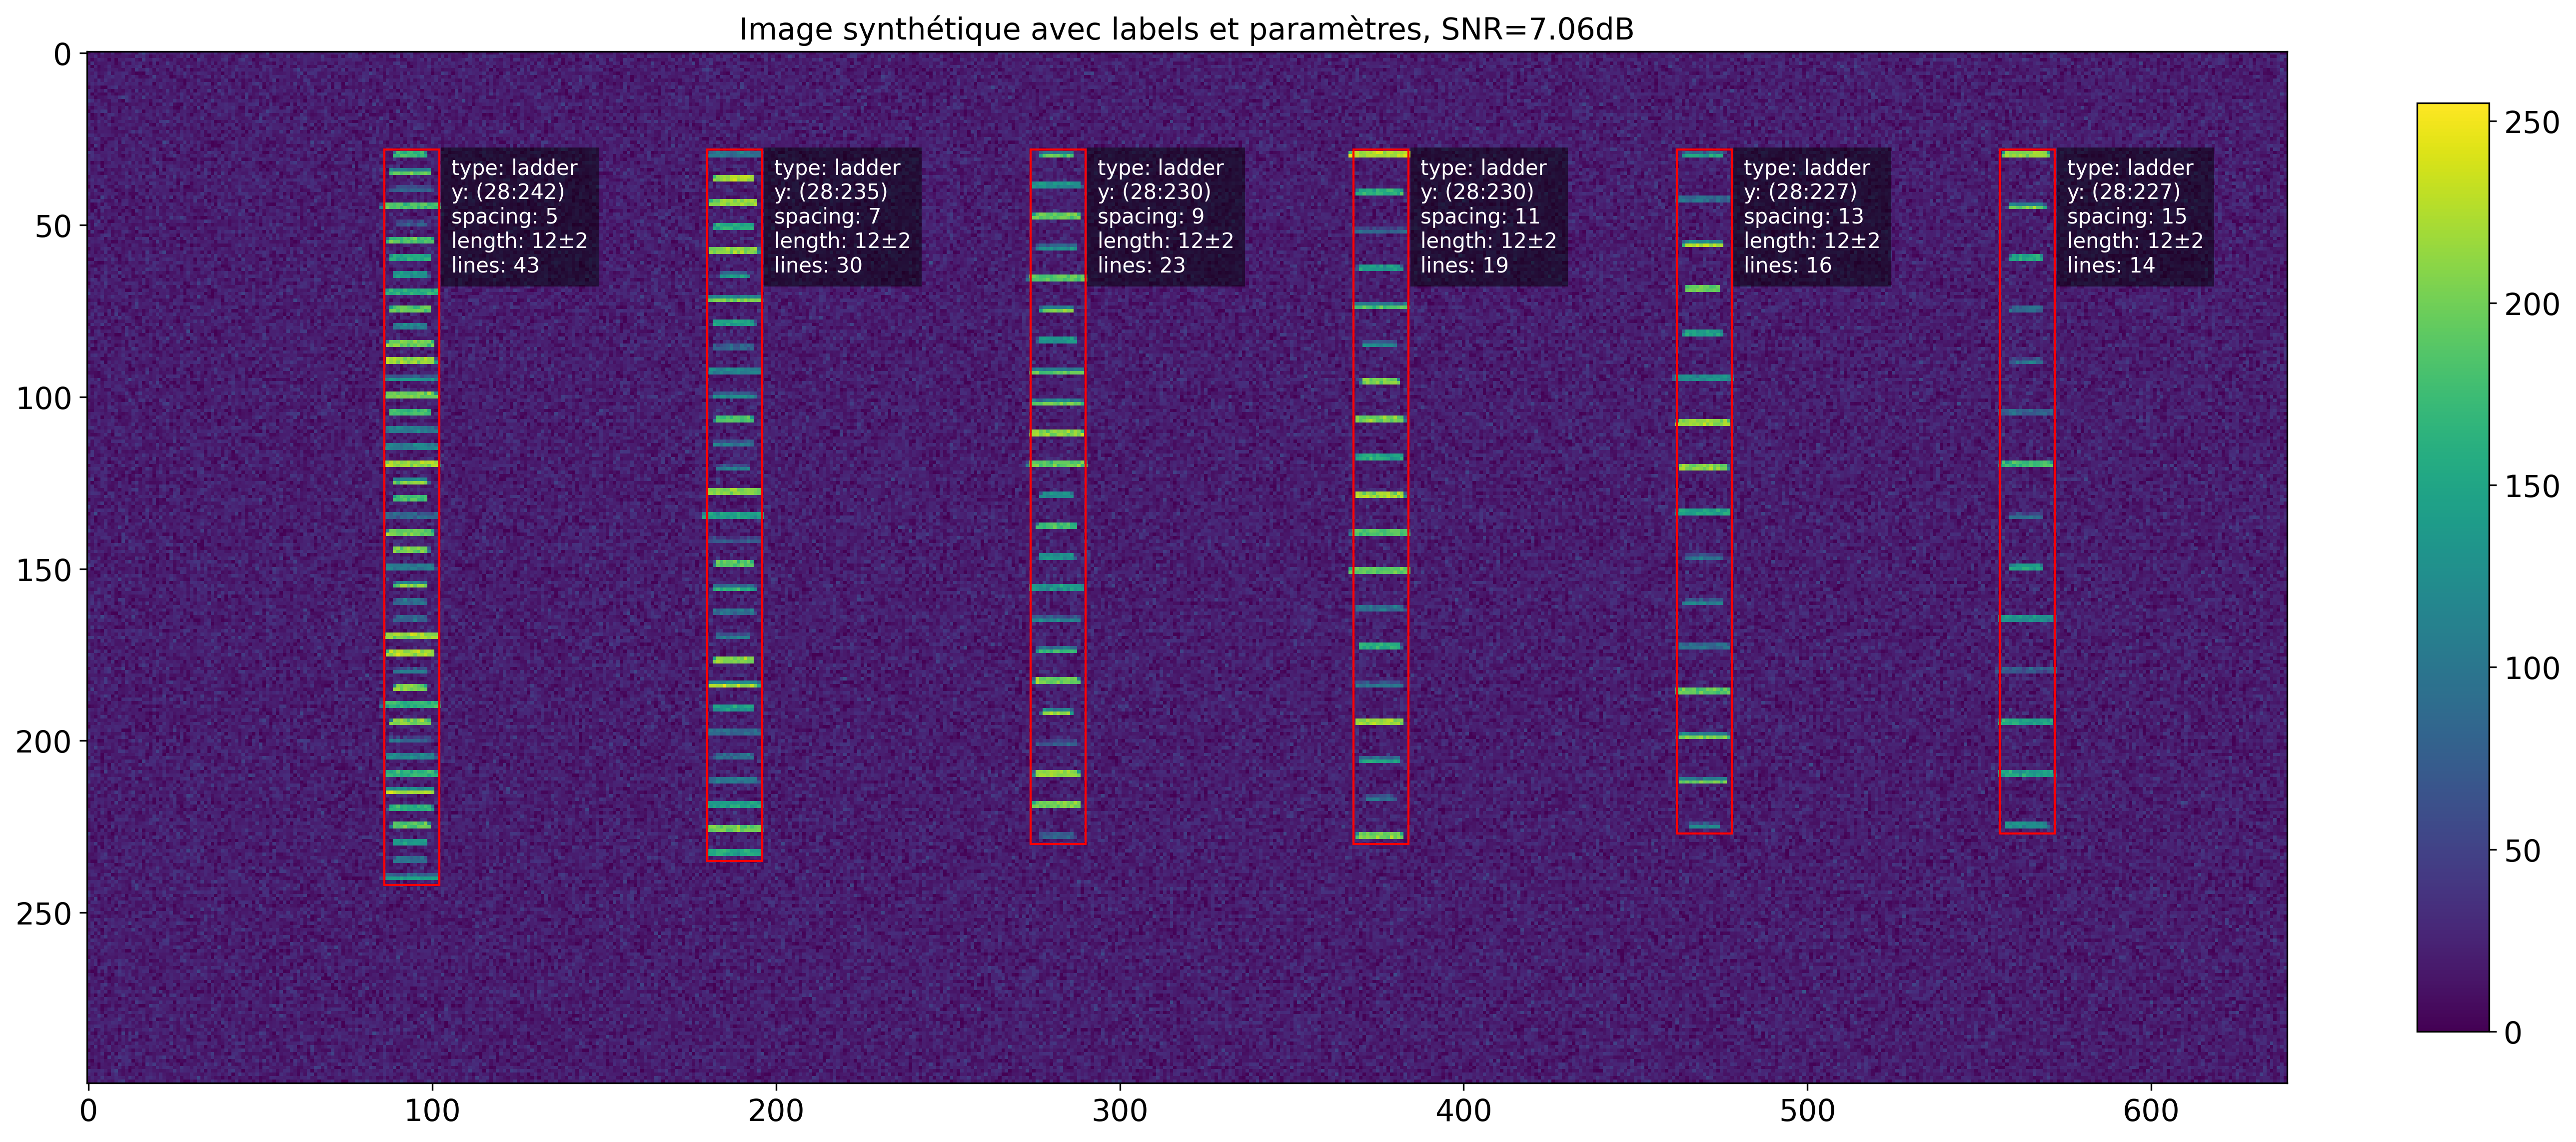

In [3]:
test = imsy.ImageSynthetique(height=300, width=640, noise_lvl=0.08, seed=50)
spacings = [5, 7, 9, 11, 13, 15]
for spacing in spacings:
  pt = [47*(spacing-3), 30]
  test.add_ladder(starting_pt = pt,
                  spacing = spacing, length = 12, l_var=2, lines = 215//spacing, seed=spacing)
test.finish()
test.show()

Enfin, on utilise la méthode `test_train`, qui fait la prédiction avec les modèles et ensuite affiche les résultats sous la forme d'images.

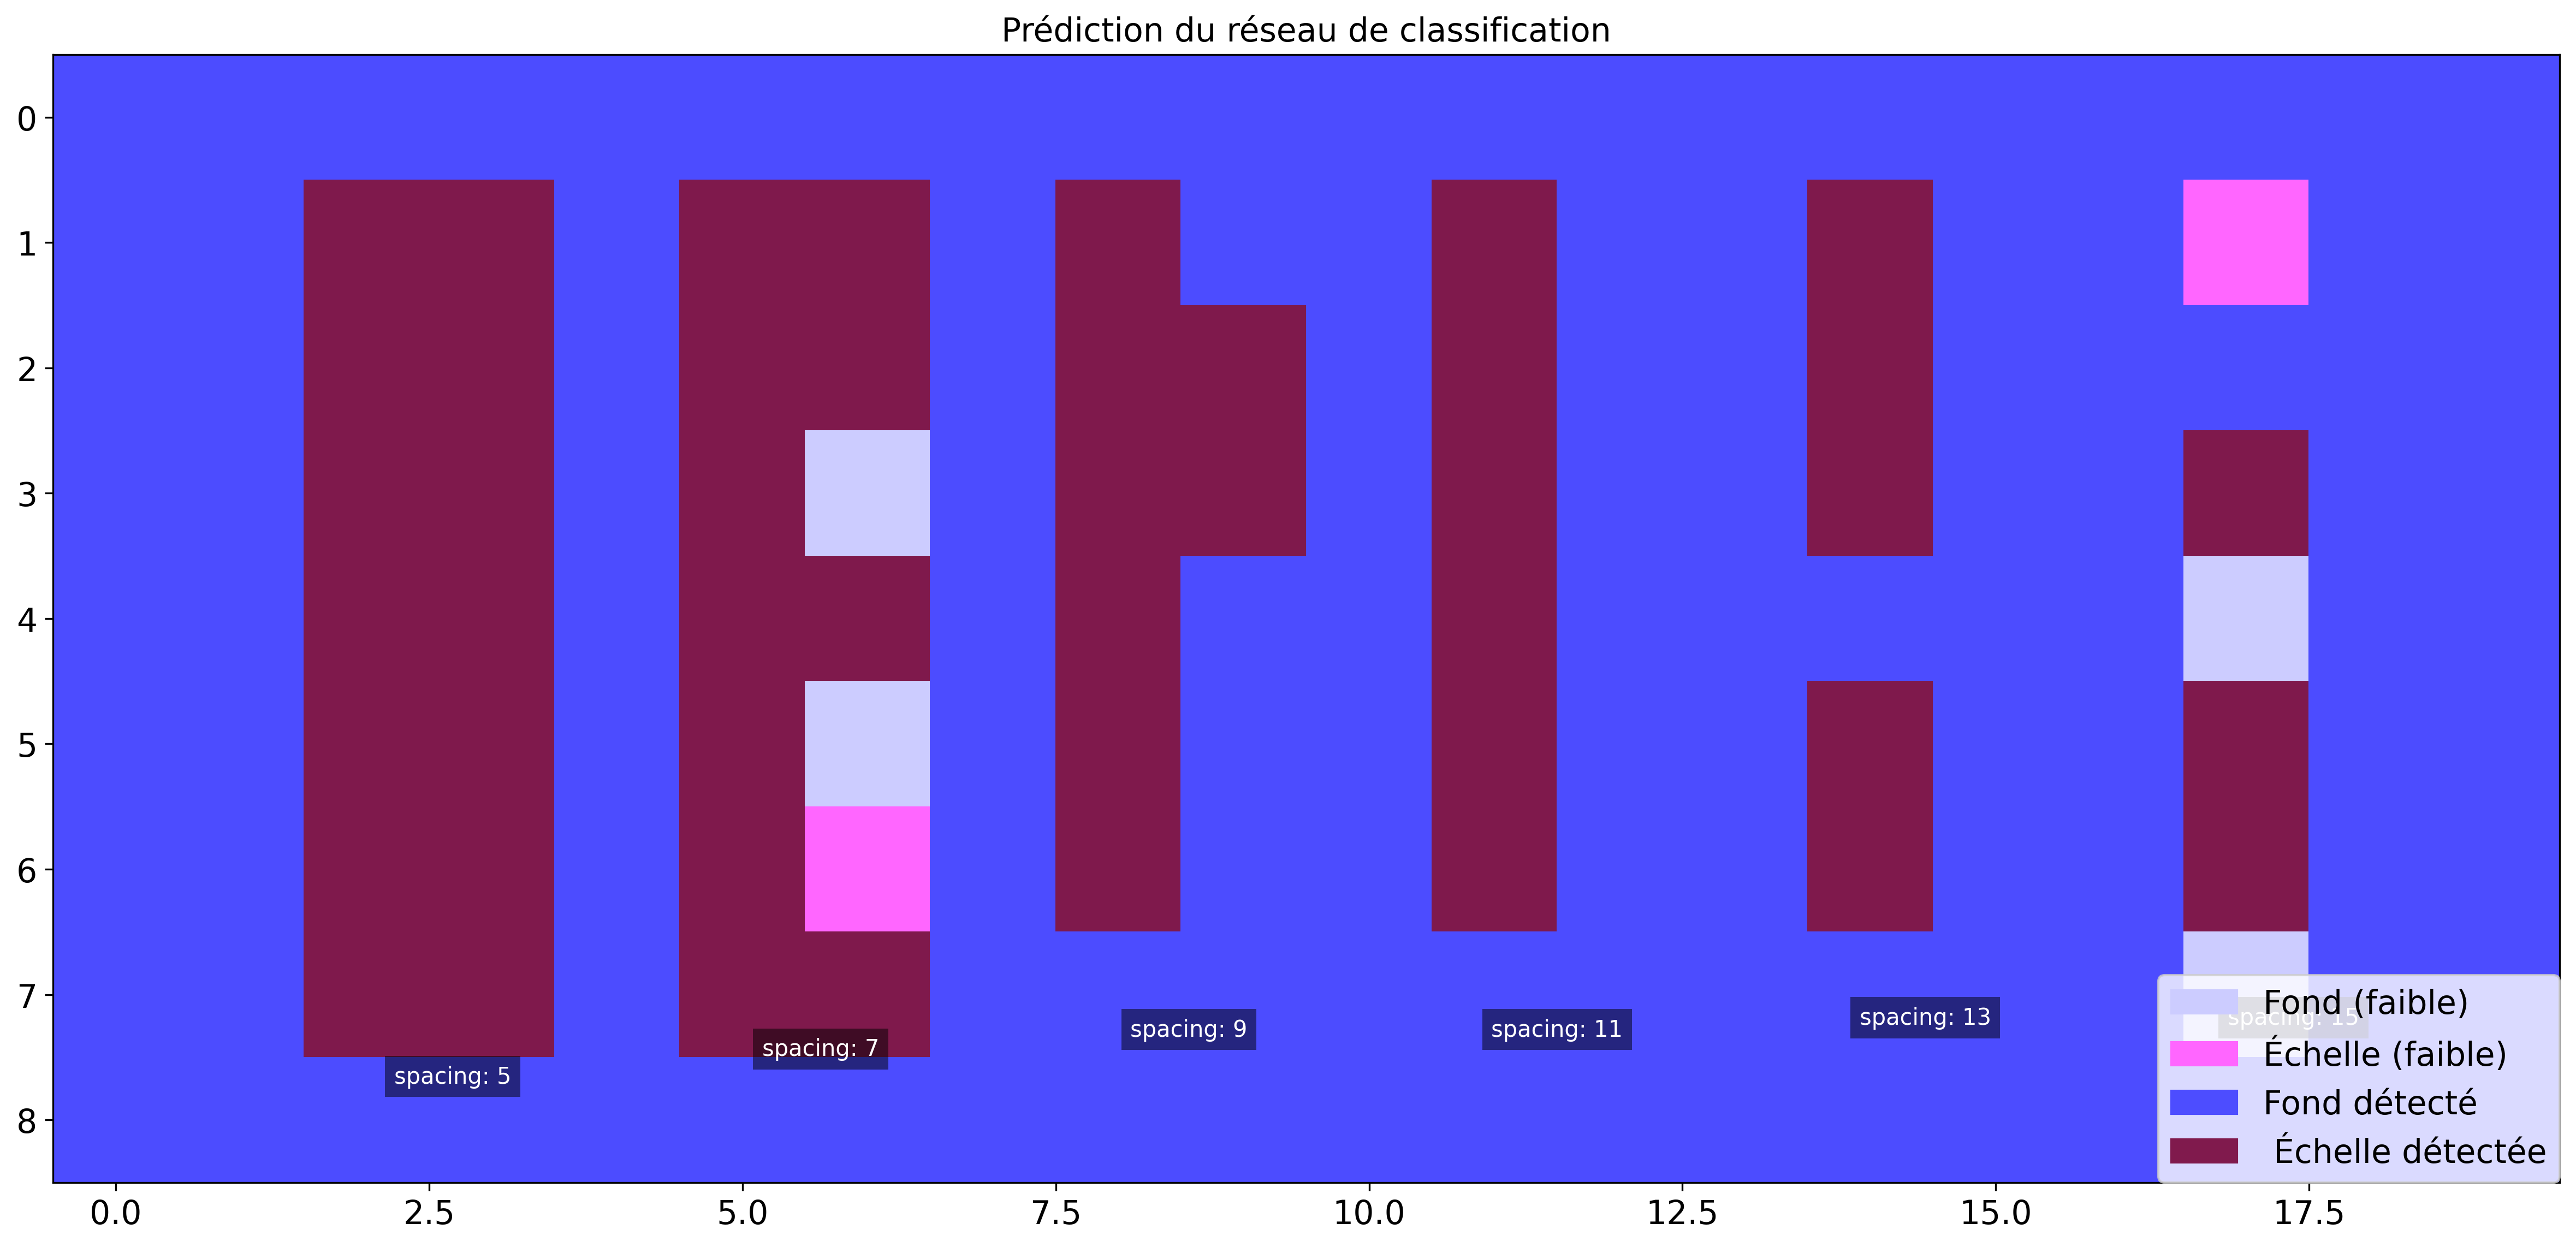

Test avec le modèle classification
Exemples avec une réponse forte: 174


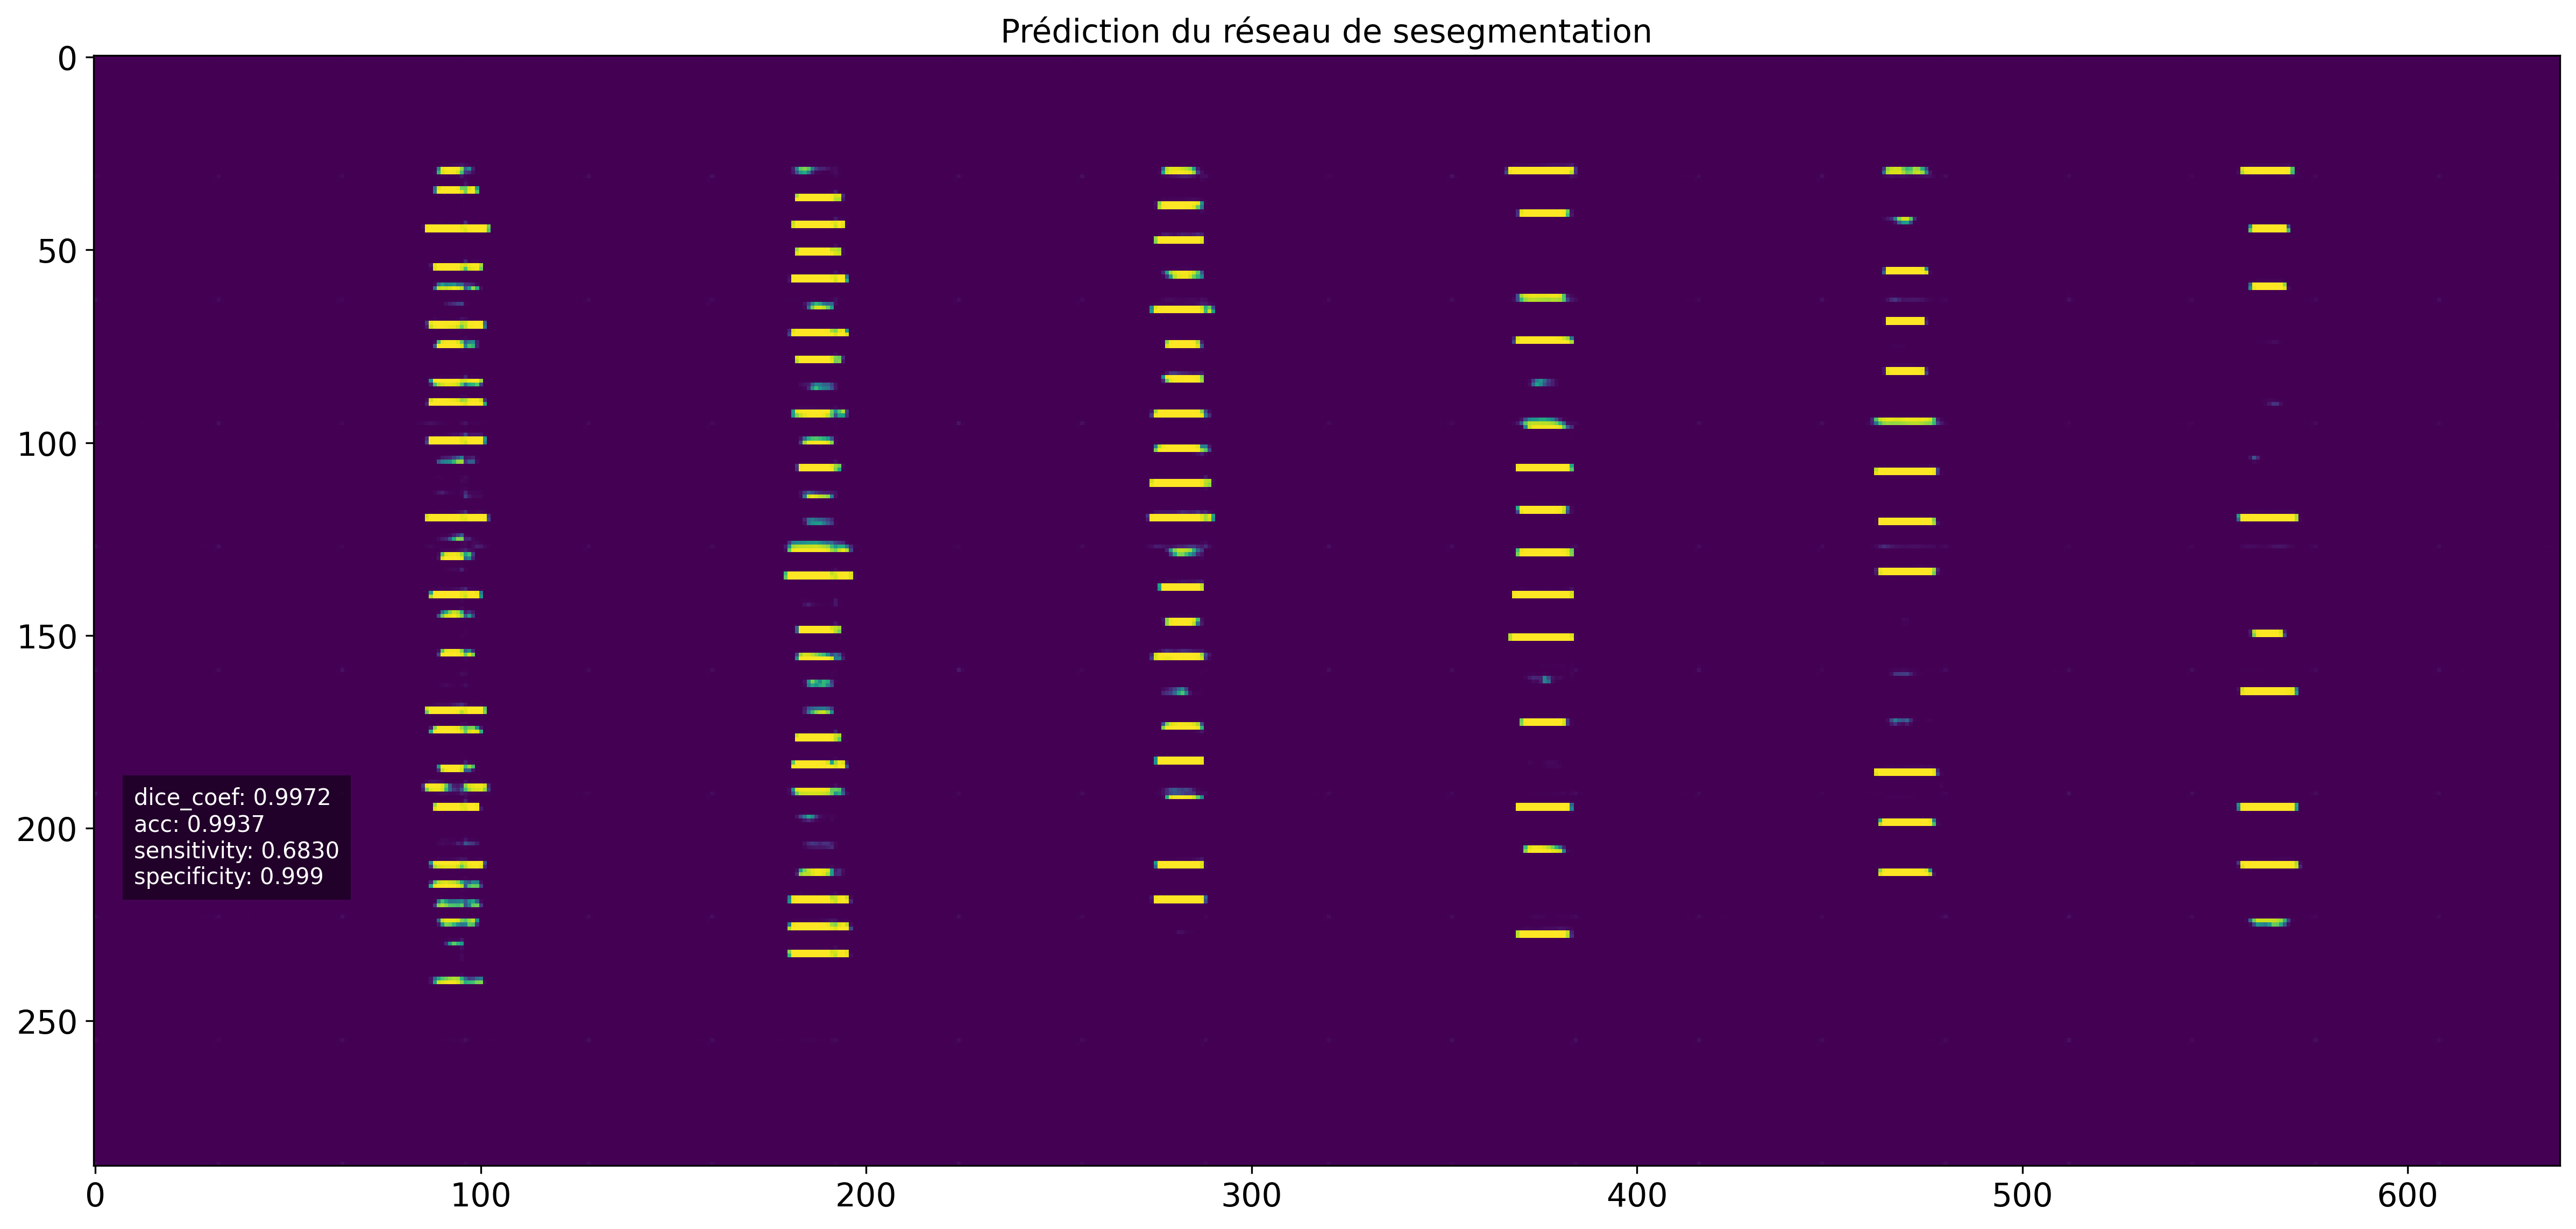

In [ ]:
test.test_train(classification_model, segmentation_model, threshold=0.8)

Dans cette fonction, il existe le paramètre booléen `learn` qui, après le test, permet d'apprendre de façon non-supervisée à partir de ces résultats. Cet auto-apprentissage est seulement implementé

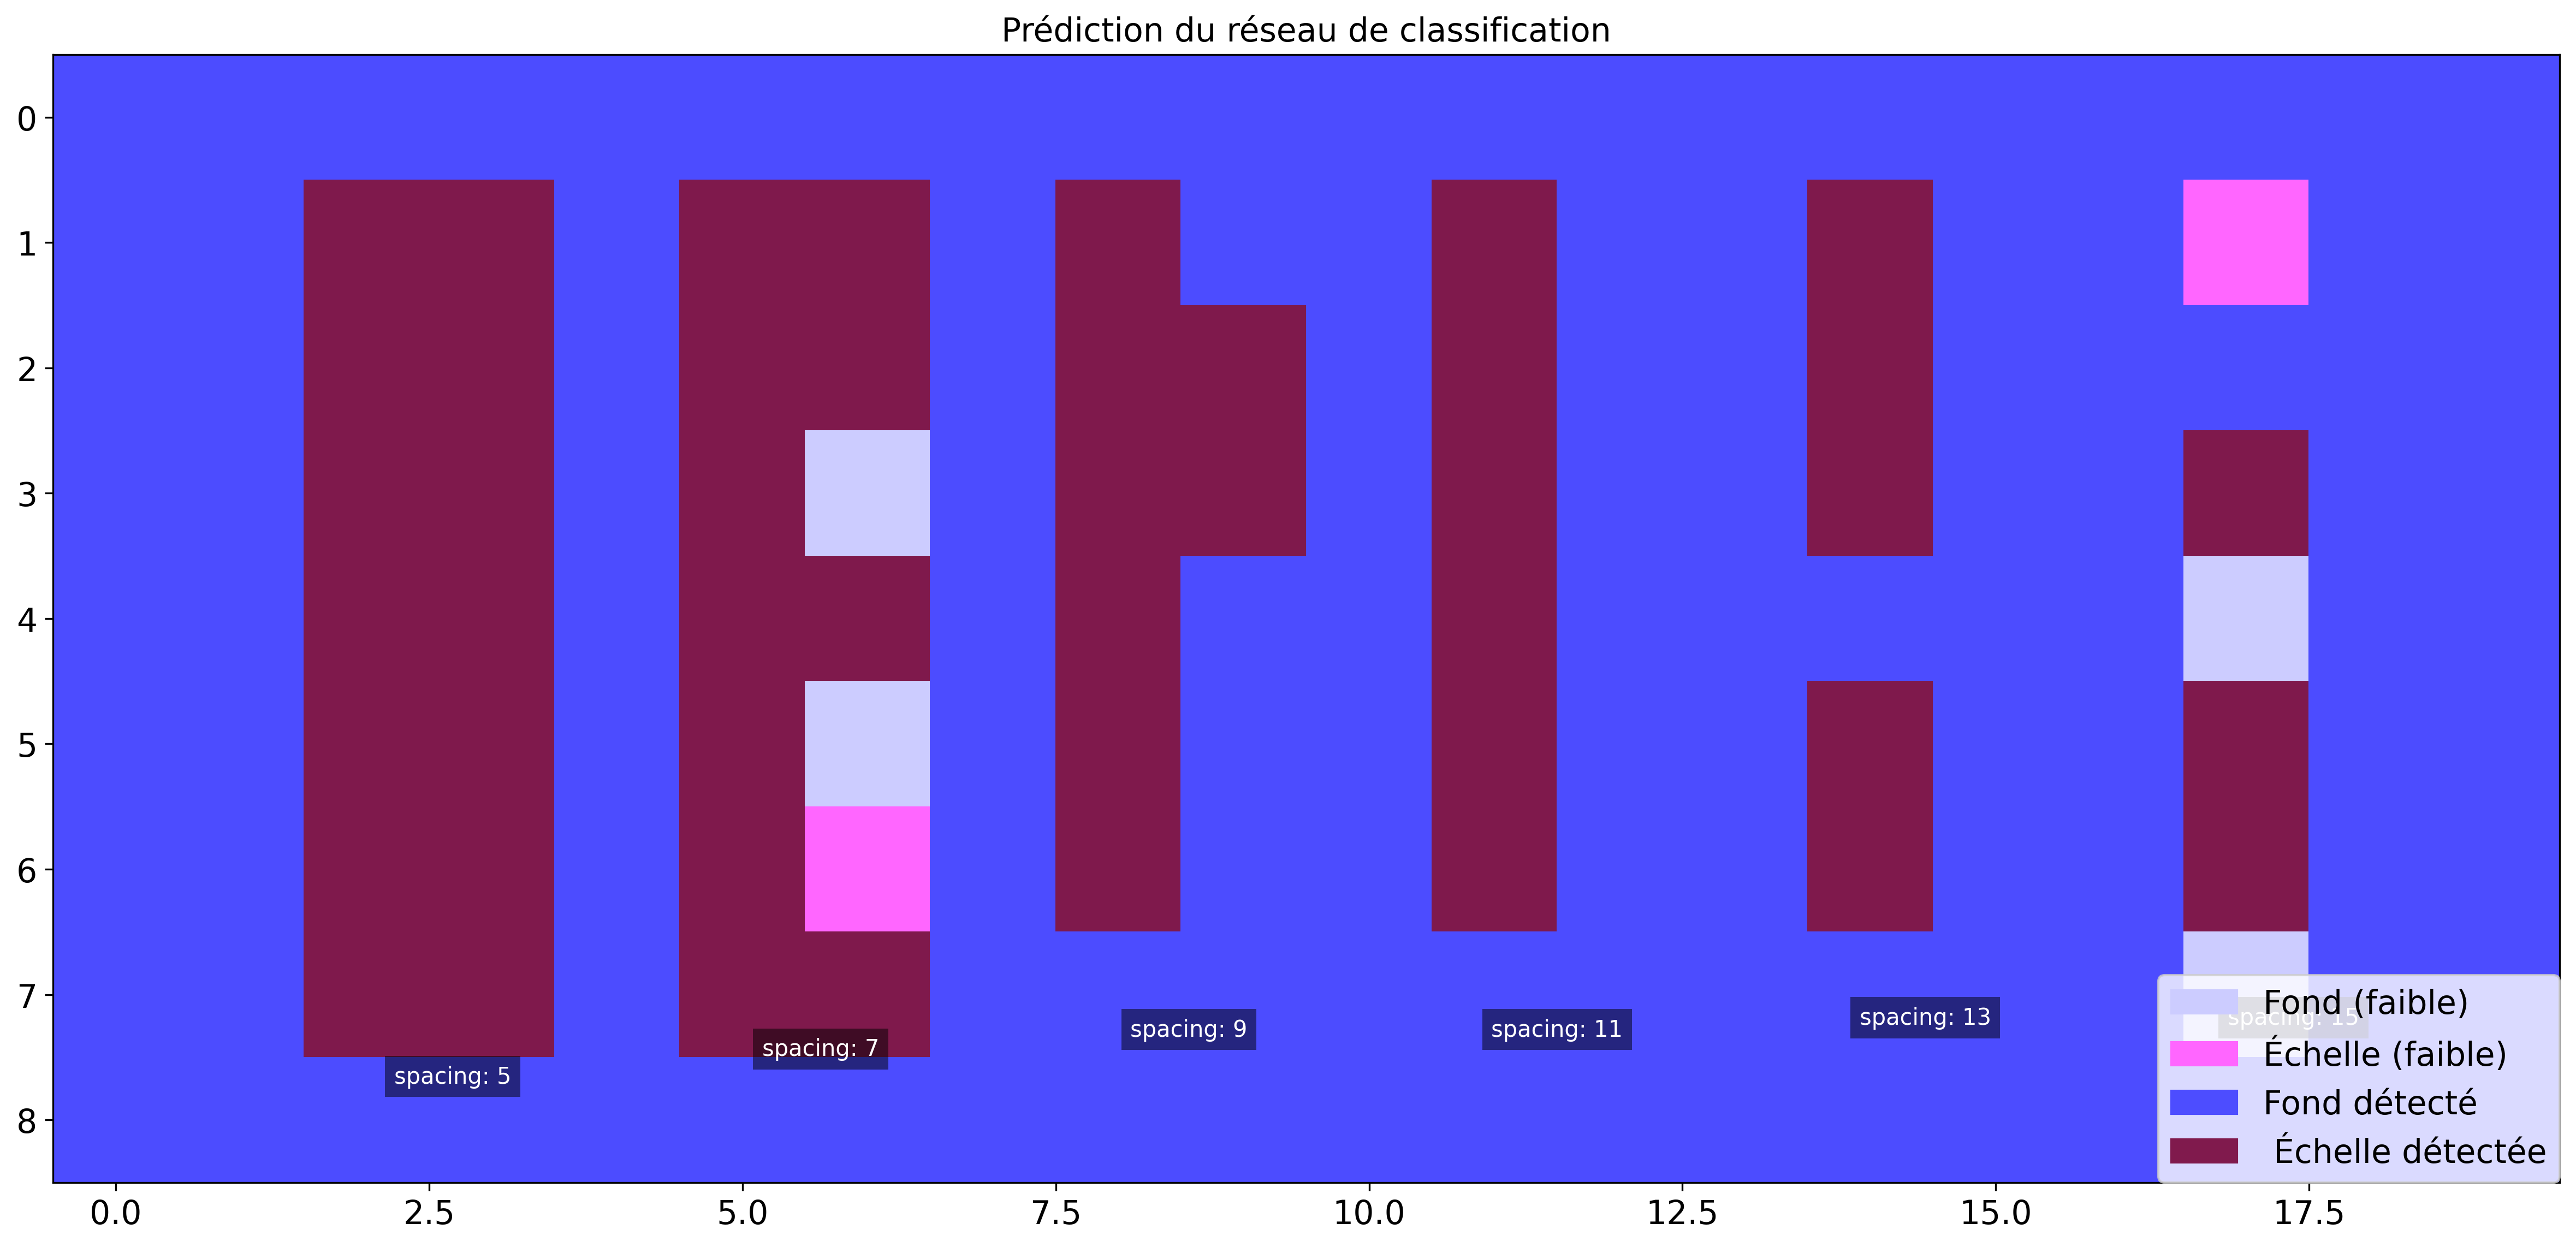

Test avec le modèle classification
Exemples avec une réponse forte: 174
Updating network with new examples
6/6 [==============================] - 14s 2s/step - loss: 0.0133 - dice_coef: 0.9994 - acc: 0.9937 - sensitivity: 0.6975 - specificity: 0.9876
classification training took 0m20.26s


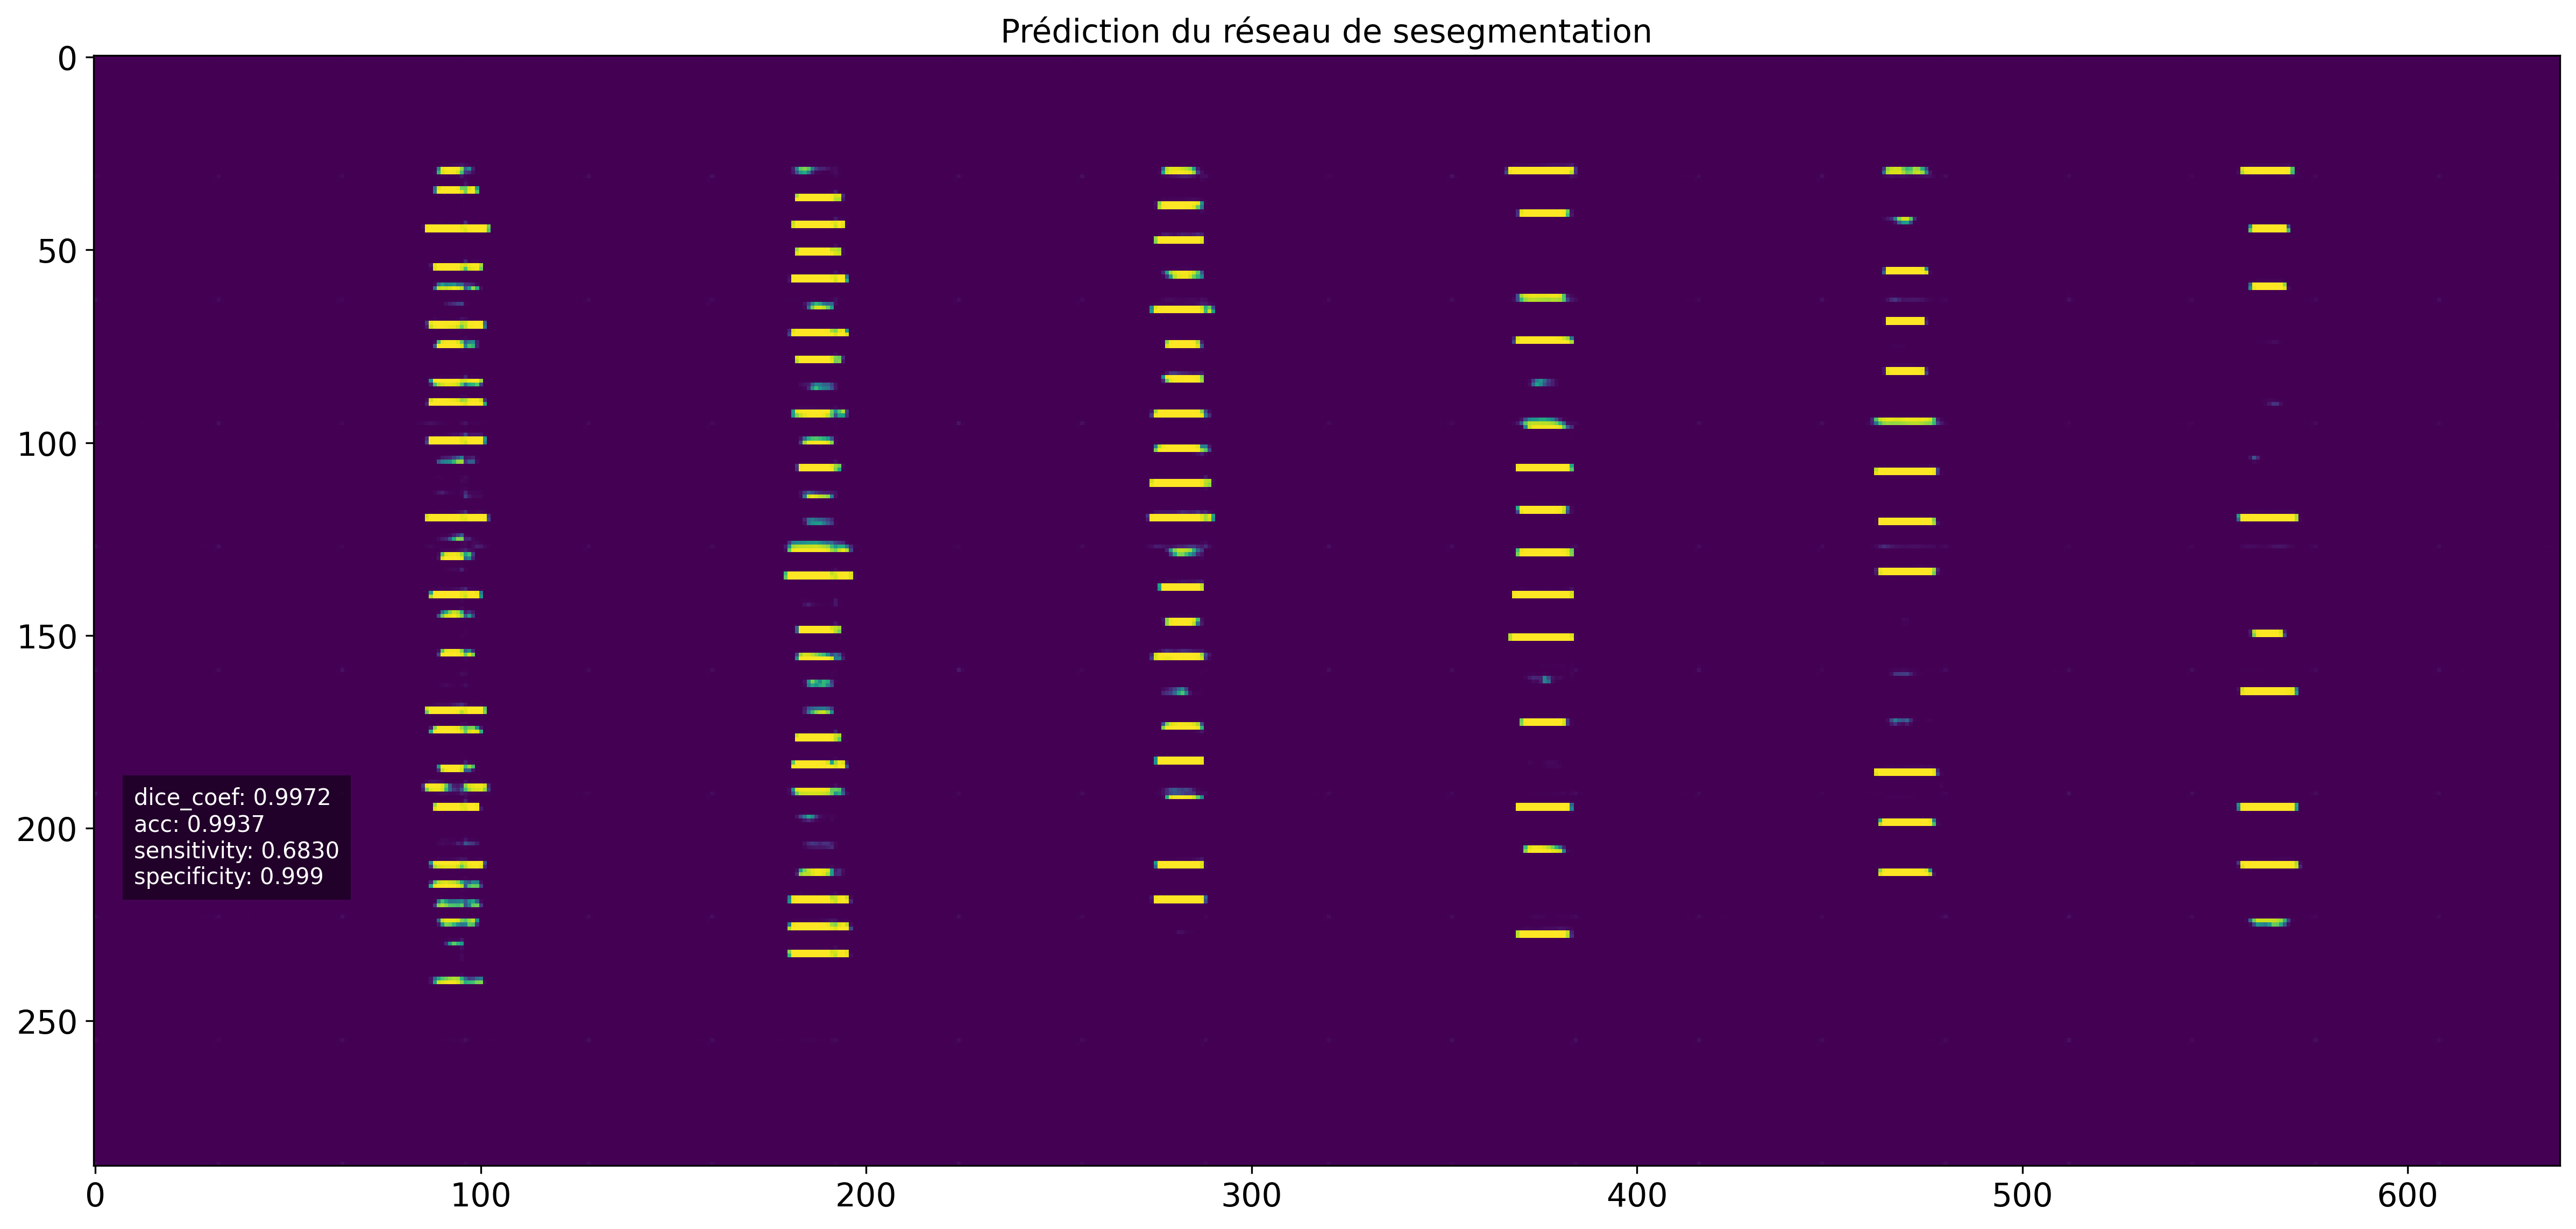

In [ ]:
test.test_train(classification_model, segmentation_model, threshold=0.8, learn=True)

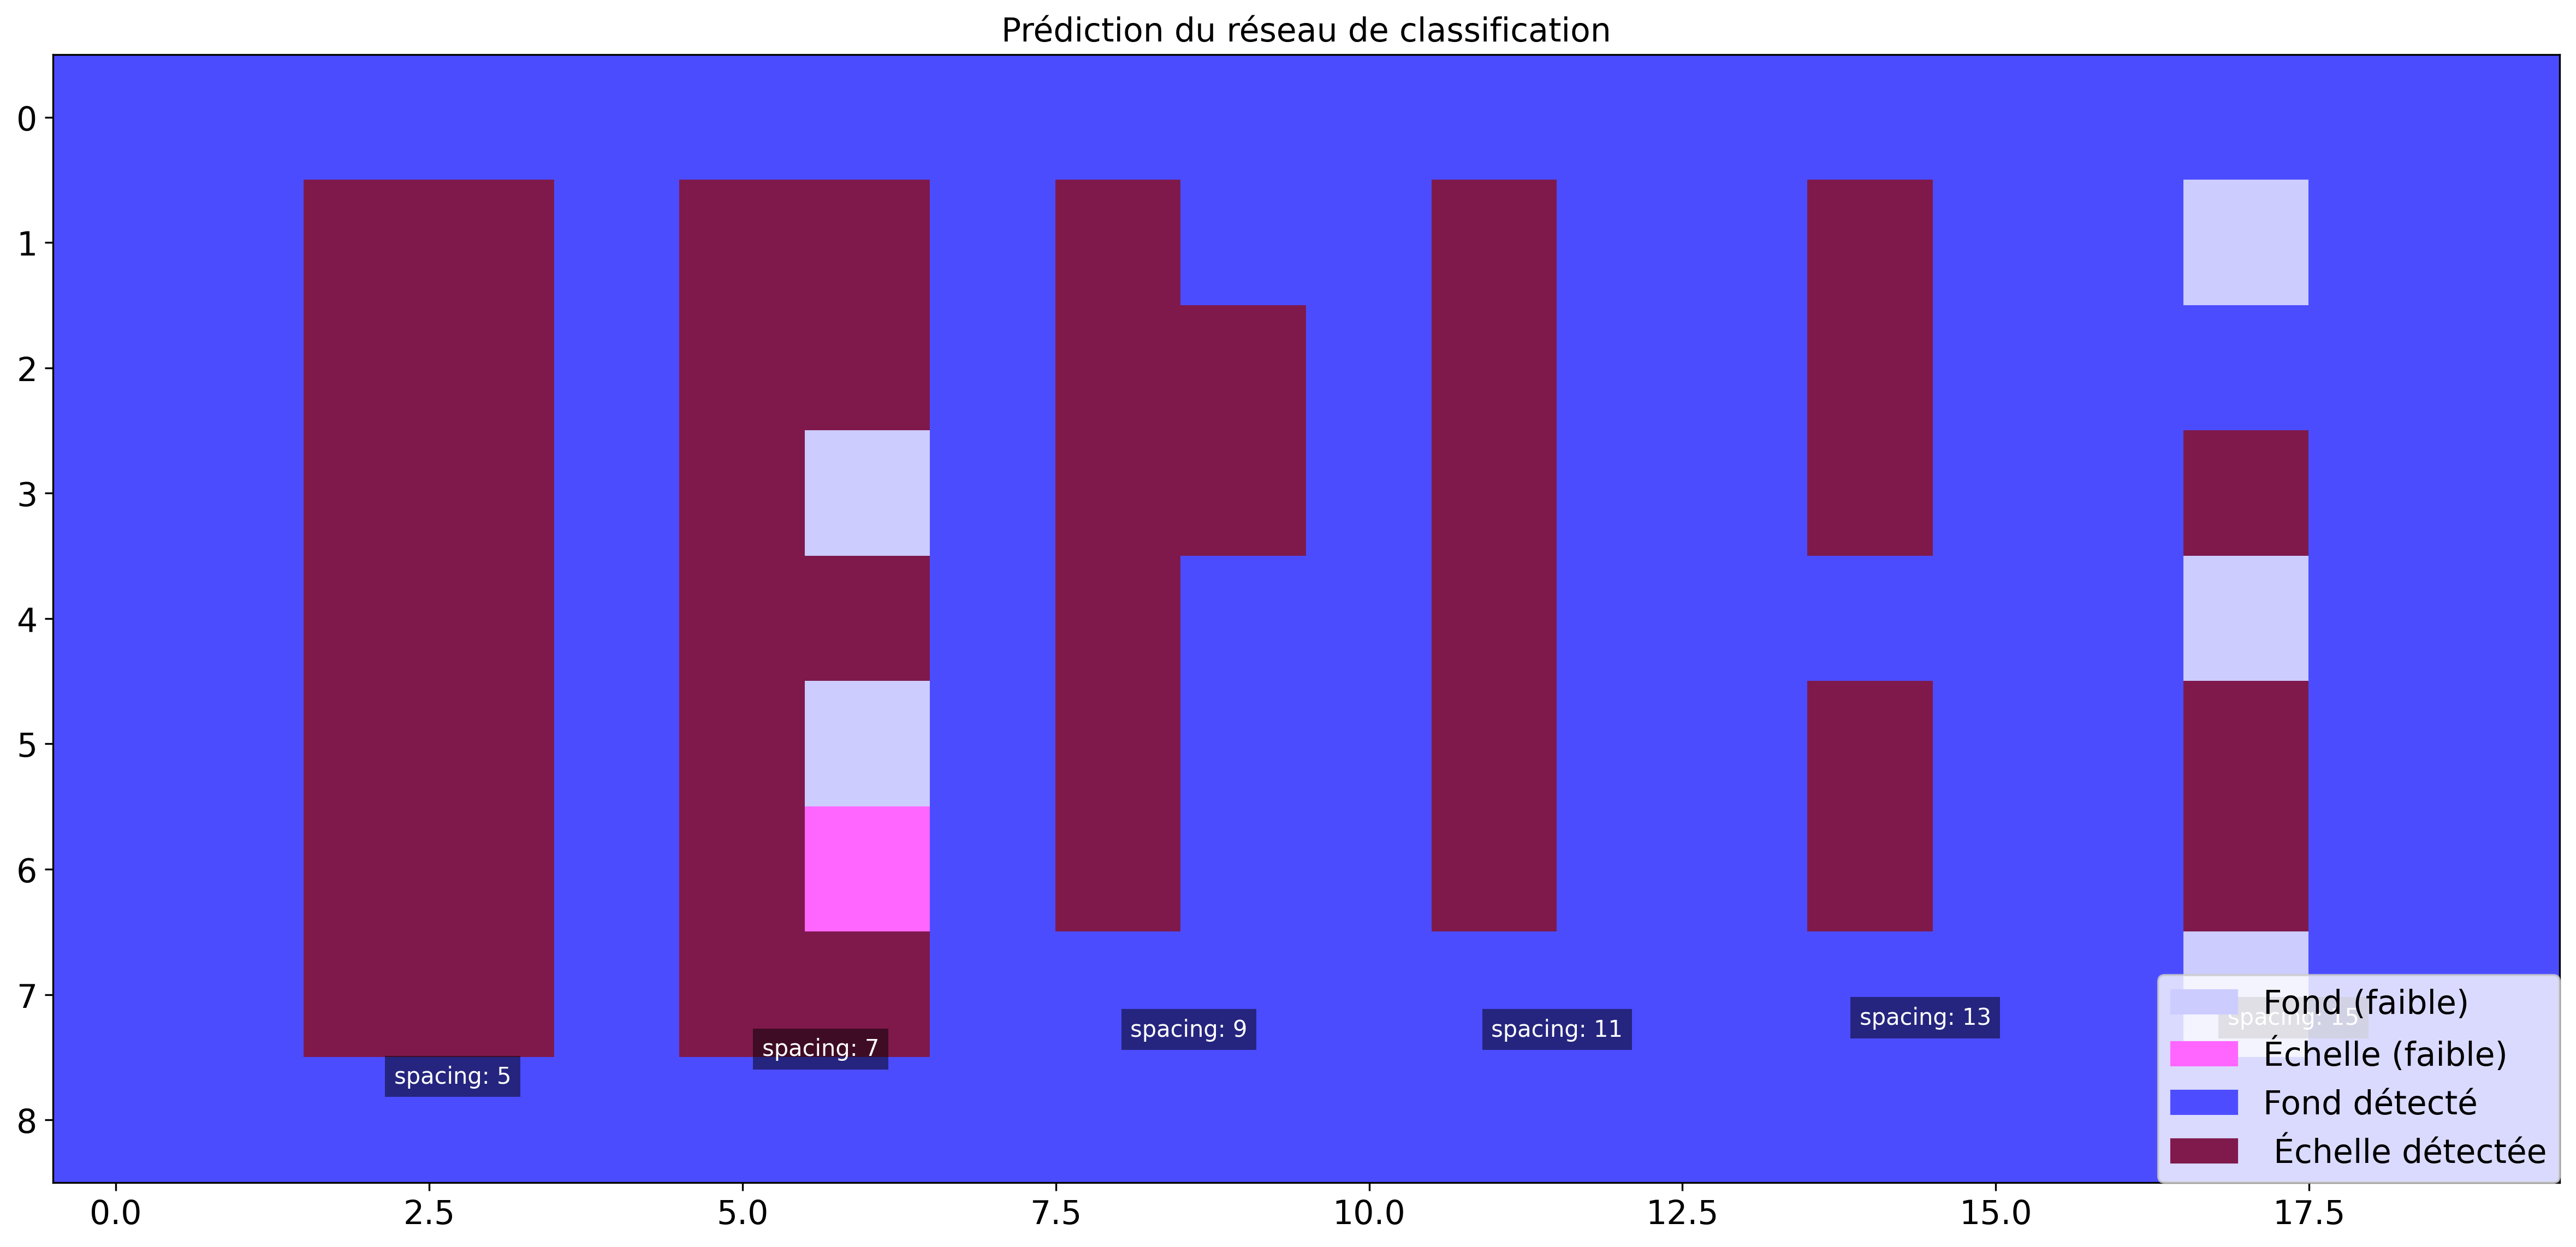

In [ ]:
_ = test.classification_predict(classification_model, threshold=0.8)